# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

### Import potřebných balíčků

In [87]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#### Načtění datasetů a základní přehled o typech ve sloupcích
 * Můžeme vidět, že jak data.csv tak i evalution.csv obsahují NaN hodnoty, které jsou potřeba nahradit. 
  * Při prochazení datasety jsem nenarazil na žádnou jinou chybející hodnotu než NaN

In [88]:
titanic = pd.read_csv('data.csv').set_index('ID')
evaluation = pd.read_csv('evaluation.csv').set_index('ID')

display(titanic.head())
display(titanic.info())

display(evaluation.head())
display(evaluation.info())

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,,,
0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   survived   1000 non-null   int64  
 1   pclass     1000 non-null   int64  
 2   name       1000 non-null   object 
 3   sex        1000 non-null   object 
 4   age        802 non-null    float64
 5   sibsp      1000 non-null   int64  
 6   parch      1000 non-null   int64  
 7   ticket     1000 non-null   object 
 8   fare       999 non-null    float64
 9   cabin      233 non-null    object 
 10  embarked   998 non-null    object 
 11  home.dest  566 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 101.6+ KB


None

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,,
1000,3,"Stankovic, Mr. Ivan",male,33.0,0,0,349239,8.6625,NaN,C,NaN
1001,1,"Flegenheim, Mrs. Alfred (Antoinette)",female,NaN,0,0,PC 17598,31.6833,NaN,S,"New York, NY"
1002,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S,"New York, NY"
1003,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,NaN,S,NaN
1004,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1000 to 1308
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     309 non-null    int64  
 1   name       309 non-null    object 
 2   sex        309 non-null    object 
 3   age        244 non-null    float64
 4   sibsp      309 non-null    int64  
 5   parch      309 non-null    int64  
 6   ticket     309 non-null    object 
 7   fare       309 non-null    float64
 8   cabin      62 non-null     object 
 9   embarked   309 non-null    object 
 10  home.dest  179 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 29.0+ KB


None

### Sloučení datasetů za účelem převodu dat
* Cat codes vyplňuje kategorický příznak v pořádí, jak jsou uvedené v datasetech. U nás můžeme vidět v pvních 5 sloupcích, že je např. home.dest jiné a tak by to převedlo na jiná zakodování, což by mohlo ovlivnit finální predikci
* Zároveň nepotřebujeme sloupec 'name', jelikož nenese žádnou užitečnou informaci o přežití 
* Po zakodování object sloupců, rozdělíme datasety stejně jak na začátku. Je to snadné, jelikož data.csv má ID 0-999 a evalution 1000-...

PS. Dozvěděl jsem se na fit_transform a transform v scikit moc pozdě, ale můj postup by neměl ovlivnit finální výsledek


In [89]:
combined = pd.concat([titanic, evaluation])
combined = combined.drop(columns=['name'])
display(combined.head())

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,,
0,0.0,3,male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0.0,3,male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,0.0,3,male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,1.0,3,female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,1.0,3,female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"


In [90]:
string_cols = combined.select_dtypes(['object']).columns
display(string_cols)

Index(['sex', 'ticket', 'cabin', 'embarked', 'home.dest'], dtype='object')

Nahrazení chybejících hodnot -1 a zakodování textových příznaků

In [91]:
combined = combined.replace(np.nan,-1)
combined[string_cols] = combined[string_cols].astype('category').apply(lambda x: x.cat.codes)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   survived   1309 non-null   float64
 1   pclass     1309 non-null   int64  
 2   sex        1309 non-null   int8   
 3   age        1309 non-null   float64
 4   sibsp      1309 non-null   int64  
 5   parch      1309 non-null   int64  
 6   ticket     1309 non-null   int16  
 7   fare       1309 non-null   float64
 8   cabin      1309 non-null   int16  
 9   embarked   1309 non-null   int8   
 10  home.dest  1309 non-null   int16  
dtypes: float64(3), int16(3), int64(3), int8(2)
memory usage: 81.8 KB


In [92]:
titanic_coded = combined.loc[:999,:]
evaluation_coded = combined.loc[1000:,:]

evaluation_coded = evaluation_coded.drop(columns=['survived'])

## Příprava trénovací, validační, testovací množiny pro učení

Nejdříve rozdělíme data na cílovou proměnnou (survived) a na matici příznaků.
Obvyklé poměry jsou takové, že ~25 % dat vezmeme jako testovací množinu a ze zbytku vezmeme ~25% jako validační množinu. Co zbude, jsou trénovací data.

Jelikož výběr modelu je hyperparametr, budeme vybírat nejlepší model na základě validační množiny.

In [93]:
Xdata = titanic_coded.iloc[:,1:]
Ydata = titanic_coded.iloc[:,0]

In [94]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

random_seed = 666

XtrainTree, XtestTree, YtrainTree, YtestTree = train_test_split(Xdata, Ydata, test_size=0.25, random_state=random_seed)
XtrainTree, XvalTree, YtrainTree, YvalTree = train_test_split(XtrainTree, YtrainTree, test_size=0.25, random_state=random_seed)

XtrainKNN, XtestKNN, YtrainKNN, YtestKNN = train_test_split(Xdata,Ydata, test_size=0.25, random_state=random_seed)
XtrainKNN, XvalKNN, YtrainKNN, YvalKNN = train_test_split(XtrainKNN, YtrainKNN, test_size=0.25,random_state=random_seed)

### Vytvoření všech možných kombinací s více hyperparametry

#### Strom
* max_depth - Určuje maximální hloubku stromu
* criterion - Značí kritérium, které se používá pro rozhodování o rozdělení dat v uzlech stromu. Může být 'entropy' nebo 'gini' , což jsou metriky pro měření nečistoty dat
* max_features - Určuje maximální počet rysů, které jsou brány v úvahu při hledání nejlepšího rozdělení.

#### KNN
* n_neighbors - Udává počet nejbližších sousedů
* weights - Určuje váhu každého souseda. 'uniform' znamená, že všichni sousedé mají stejnou váhu, 'distance' znamená, že váha je inverzně úměrná vzdálenosti.
* metric - Označuje metriku vzdálenosti, která se používá k určení blízkosti sousedů


In [95]:
param_grid_tree = {
    'max_depth': range(1,30),
    'criterion': ['entropy', 'gini'],
    'max_features': [None,'sqrt','log2'],
}
param_comb_tree = ParameterGrid(param_grid_tree)

param_grid_knn = {
    'n_neighbors': range(2,30),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}
param_comb_knn = ParameterGrid(param_grid_knn)

train_acc_tree = []
val_acc_tree = []

train_acc_knn = []
val_acc_knn = []

# Strom

#### VÝHODY
* Interpretovatelnost - proces je podobný lidskému myšlení a snadno se dají vysvětlit
* Schopnost pracovat s kategoriálními i numerickými daty - Rozhodovací stromy dokážou pracovat s kategoriálními i numerickými daty bez nutnosti předchozí normalizace dat
* Efektivní

#### NEVÝHODY
* Overfitting - mají tendenci k přeučení (overfittingu) na tréninkových datech, což může vést k jejich špatné generalizaci na nová data
* Citlivost na malé změny - Malé změny v datech mohou způsobit výrazné změny ve struktuře rozhodovacího stromu.

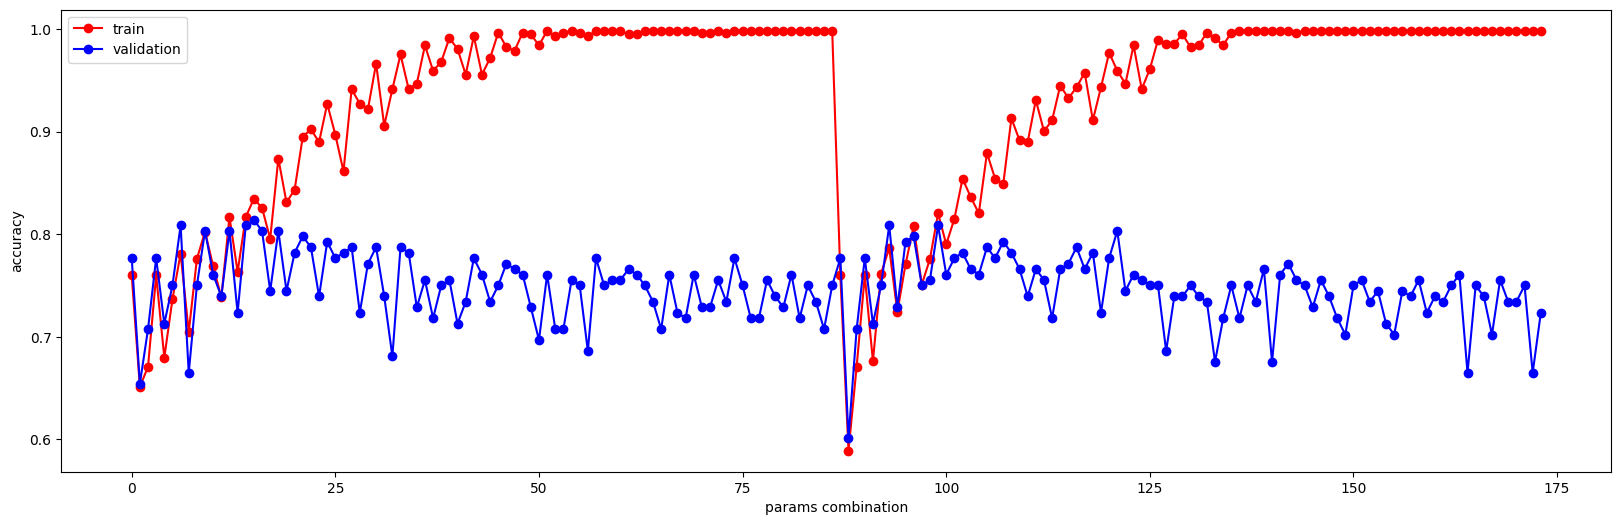

In [96]:
for params in param_comb_tree:
    current_tree = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'], max_features=params['max_features'])
    current_tree.fit(XtrainTree,YtrainTree)
    train_acc_tree.append(metrics.accuracy_score(YtrainTree, current_tree.predict(XtrainTree)))
    val_acc_tree.append(metrics.accuracy_score(YvalTree, current_tree.predict(XvalTree)))

plt.figure(figsize=(20,6))
plt.plot(train_acc_tree,'or-')
plt.plot(val_acc_tree,'ob-')
plt.xlabel('params combination')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
best_params_tree = param_comb_tree[np.argmax(val_acc_tree)]    

# KNN

#### VÝHODY
* Jednoduchost implementace
* Schopnost zachytit složité vzory

#### NEVÝHODY
* Závislost na volbě K
* Potřeba normalizace dat: KNN je citlivý na škálování a vzdálenostní metriky. Pokud jsou funkce v datasetu na různých škálách
* Nízká efektivita v datech s vysokým počtem dimenzí: Pro datasety s vysokým počtem dimenzí

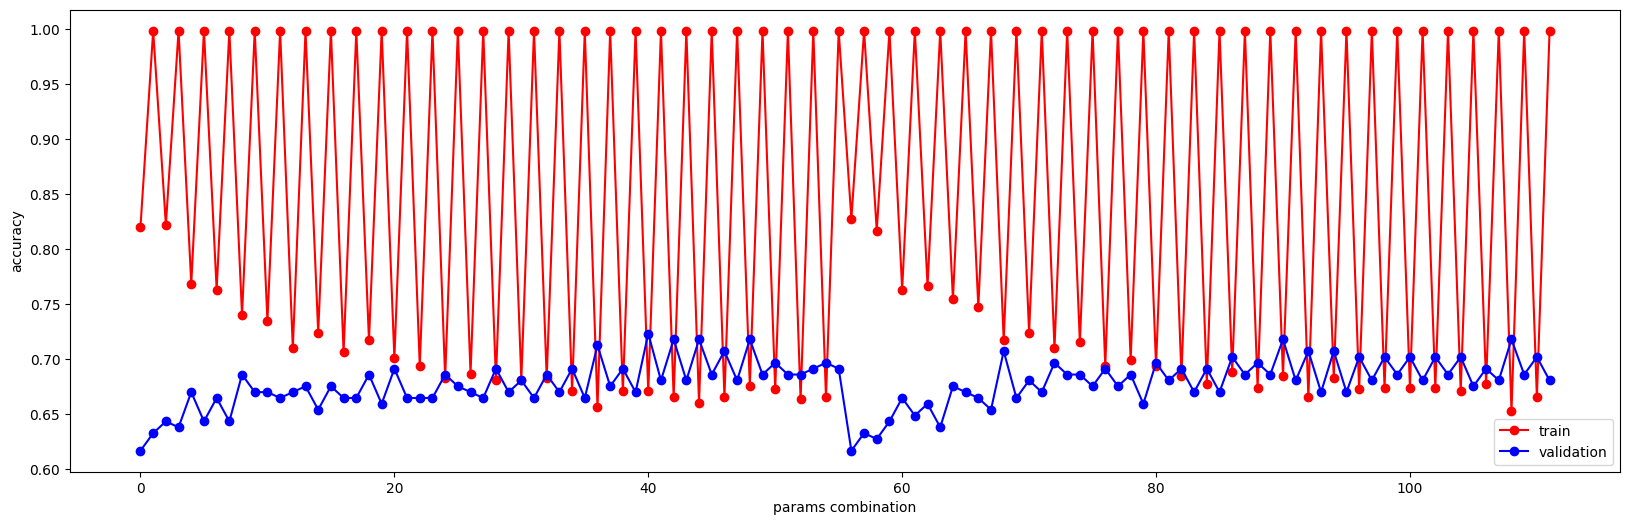

In [97]:
for params in param_comb_knn:
    current_knn = KNeighborsClassifier(n_neighbors=params['n_neighbors'],weights=params['weights'],metric=params['metric'])
    current_knn.fit(XtrainKNN, YtrainKNN)
    train_acc_knn.append(metrics.accuracy_score(YtrainKNN, current_knn.predict(XtrainKNN)))
    val_acc_knn.append(metrics.accuracy_score(YvalKNN, current_knn.predict(XvalKNN)))
    
best_params_knn = param_comb_knn[np.argmax(val_acc_knn)]
plt.figure(figsize=(20, 6))
plt.plot(train_acc_knn, 'or-')
plt.plot(val_acc_knn, 'ob-')
plt.xlabel('params combination')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
best_params_tree = param_comb_tree[np.argmax(val_acc_tree)]

### Výpis nejlepších hyperparamatrů pro strom a kNN

In [98]:
print('best tree params ', best_params_tree)
print('best knn params ', best_params_knn)

best tree params  {'max_features': None, 'max_depth': 6, 'criterion': 'entropy'}
best knn params  {'weights': 'uniform', 'n_neighbors': 22, 'metric': 'minkowski'}


### Určení nejlepšího modelů s nejlepšími hyperparametry pro jednotlivé modely

In [99]:
best_tree = DecisionTreeClassifier(**best_params_tree)
best_tree.fit(XtrainTree,YtrainTree)

print('accuracy score tree(train): {0:.6f}'.format(metrics.accuracy_score(YtrainTree, best_tree.predict(XtrainTree))))
print('accuracy score tree(validation): {0:.6f}'.format(metrics.accuracy_score(YvalTree, best_tree.predict(XvalTree))))

best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(XtrainKNN, YtrainKNN)
print('accuracy score knn(train): {0:.6f}'.format(metrics.accuracy_score(YtrainKNN, best_knn.predict(XtrainKNN))))
print('accuracy score knn(validation): {0:.6f}'.format(metrics.accuracy_score(YvalKNN, best_knn.predict(XvalKNN))))

accuracy score tree(train): 0.834520
accuracy score tree(validation): 0.808511
accuracy score knn(train): 0.670819
accuracy score knn(validation): 0.723404


## Nejlepší model

Z přesnosti na validační množině ( model je také hyperparametr) můžeme vidět, že strom vyhrává. Toto bude náš výsledný model pro predikci
Spočítáme předpoklad pro testovácí množinu, F1, AUC

#### Testovací přesnost
* V tomto případě 80 % z testovacího datasetu bylo klasifikováno správně pomocí tohoto modelu.

#### F1
* Model dosahuje slušného kompromisu mezi přesností a úplností ve svých klasifikacích na testovacím datasetu

#### AUC
* Tento model má poměrně dobré schopnosti rozlišování mezi třídami v testovacím datasetu. Čím vyšší hodnota AUC, tím lepší je schopnost modelu odlišit mezi třídami.


Best model params: 
Decision Tree{'max_features': None, 'max_depth': 6, 'criterion': 'entropy'}
Test accuracy of best model: 0.800000
F1 score best_tree (test): 0.722222
AUC best_tree (test): 0.810727


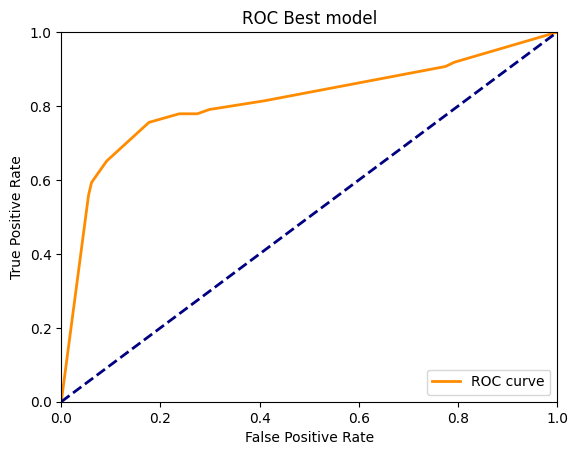

In [104]:
print(f'Best model params: \nDecision Tree{best_params_tree}')
print(f'Test accuracy of best model: {best_tree.score(XtestTree,YtestTree):0.6f}')

f1_score = metrics.f1_score(YtestTree,best_tree.predict(XtestTree))
print('F1 score best_tree (test): {0:.6f}'.format(f1_score))

y_prediction_probability = best_tree.predict_proba(XtestTree)
fpr, tpr, threshold = metrics.roc_curve(YtestTree,y_prediction_probability[:,1])
roc_auc = metrics.auc(fpr, tpr)
print('AUC best_tree (test): {0:.6f}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Best model')
plt.legend(loc='lower right')
plt.show()

## Finální predikce

Ještě jednou zkontrolujeme, jestli neobsahuje žádné sloupce navíc a je totožný s tím, co na začátku
A výslednou predikci zapišeme do souboru resulsts.csv

In [101]:
display(evaluation_coded.head())

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,
1000,3,1,33.0,0,0,522,8.6625,0,1,0
1001,1,0,-1.0,0,0,815,31.6833,0,3,237
1002,1,0,-1.0,1,0,827,133.6500,0,3,237
1003,3,1,47.0,0,0,419,9.0000,0,3,0
1004,1,0,58.0,0,0,802,146.5208,57,1,0


In [102]:
predictions = best_tree.predict(evaluation_coded)
predictions = predictions.astype(int)
results = pd.DataFrame({'ID':evaluation_coded.index, 'survived': predictions})

results.to_csv('results.csv',index=False)

# Just curious for difference
predictionsknn = best_knn.predict(evaluation_coded)
predictionsknn = predictionsknn.astype(int)
resultsknn = pd.DataFrame({'ID':evaluation_coded.index, 'survived': predictionsknn})

resultsknn.to_csv('resultsknn.csv',index=False)

In [103]:
# Just checking how much diff there is 
display(results.survived.value_counts())
display(resultsknn.survived.value_counts())

survived
0    220
1     89
Name: count, dtype: int64

survived
0    226
1     83
Name: count, dtype: int64